In [15]:
import datetime
from pytz import timezone

# from collections import OrderedDict
from copy import deepcopy

import pickle
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

RESULT_PATH = './model_results/'

In [6]:
# PARAMETERS FOR 
LAMBDA_PEN = 1000
L_BOUND = -10
U_BOUND = 10
N_POINTS = 512

NUM_EPOCHS = 15000

M_POINTS = 10
ALPHA = 2

SELECTION_RATE = 0.2

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [7]:
class sinFn(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [8]:
def model_on_interval(nn_model, discrete_points):
    x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in discrete_points]

    model_output = []
    for i in x_vals:
        model_output.append(nn_model(i).detach().numpy().item())
    return model_output

In [59]:
test_pf.M_points

10

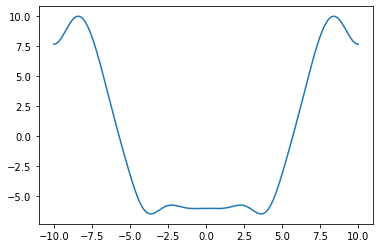

In [53]:
test_pf = Potential_Function()
test_pf.plot_function(DISCRETE_POINTS)

In [54]:
test_pf.update_potential_fn(DISCRETE_POINTS)

Original min val = -6.502646782019543
Min val with c_0 updated = 0.4973532179804572
Final min and max vals are 1.1461748002917482, 6.0


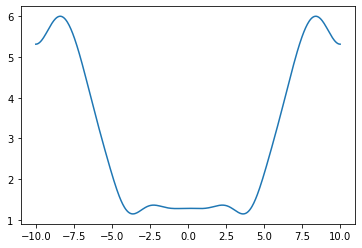

In [55]:
test_pf.plot_function(DISCRETE_POINTS)

In [109]:
epsilon_Loss_penalty(p_fn1, model_21_sin, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)

(tensor([2.9881], grad_fn=<MulBackward0>),
 tensor([2.9881], grad_fn=<AddBackward0>))

2.2998316982551303


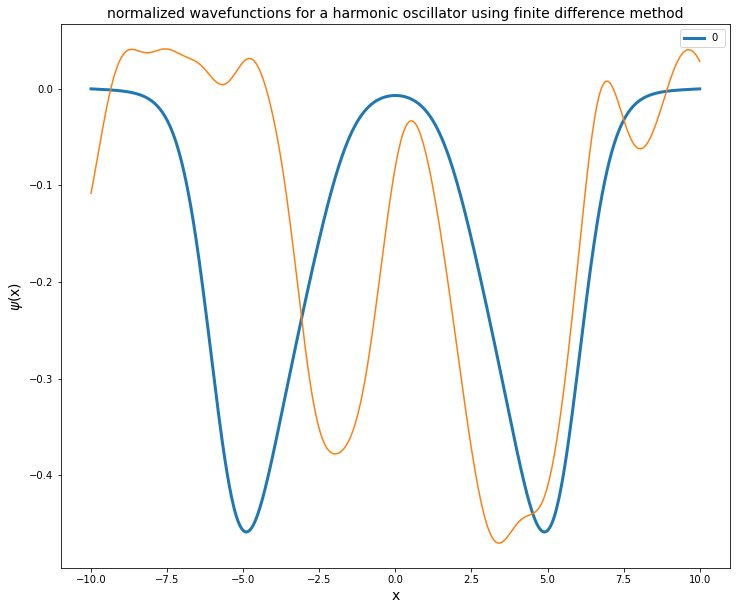

In [108]:
eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn1)
print(eig_val[0])
plot_finite_diff_sol(eig_val, -ground_state, DISCRETE_POINTS, model_21_sin)

In [ ]:
test_21_sin = auto_test_documentation(model_21_sin, adam_opt_21_sin, test_pf, 
                                      model_name='model_21_sin_test',
                                      res_path=RESULT_PATH,
                                      loss_fname='loss_21_sin_test',
                                      loss_with_pen_fname = 'loss_pen_21_sin_test')

In [10]:
class X_Square_sin:
    def __init__(self, const, use_sin=False):
        self.const = const
        if use_sin == True:
            self.sin_const = np.random.choice(np.arange(10, 50))
        
    def forward(self, x):
        return x**2 + self.const + self.sin_const*math.sin(x)
    
class Potential_Function:
    def __init__(self, c_0=0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA, 
                 rescale=1):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        self.rescale = 1
        self.is_updated = False
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = []
        for i in range(1, self.M_points+1):
            c_i = self.L_endpoint/(i * math.pi)
            c_i = (c_i)**self.alpha
            self.ci_list.append(c_i)
                        
        
    def forward(self, x):
        """
        V(x) = rescale * (c_0 + SUM(...))
        
        """
        f_value = 0
        summation = 0
        
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0
        return self.rescale * f_value
    
    def set_c0_value(self, val):
        self.c_0 = val
        return
    
    def set_rescale_factor(self, val):
        self.rescale = val
        return 
    
    def plot_function(self, discrete_points):
        y_values = [self.forward(i) for i in discrete_points]
        plt.plot(discrete_points, y_values)
    
    def update_potential_fn(self, discrete_points):
        if self.is_updated == True:
            raise Exception("Potential Function is updated")
        else:
            # (1) Check lowest value to set appropriate c_0 value:
            min_val = min([self.forward(i) for i in discrete_points])
            print("Original min val = " + str(min_val))

            # (2) Set c_0 value s.t. every value in y_values is > 0: 
            if min_val < 0:
                c_0 = math.ceil(abs(min_val))
                self.set_c0_value(c_0)
                new_y = [self.forward(i) for i in discrete_points]
                print("Min val with c_0 updated = " + str(min(new_y)))
            
            # (3) Rescale potential function s.t. every value lies between 0 and 5:
            new_y = [self.forward(i) for i in discrete_points]
            max_v = max(new_y)
            rescale = 5/max_v
            self.set_rescale_factor(rescale)
        
            # (4) Update c_0 one more time to ensure min_val > 1:
            new_y = [self.forward(i) for i in discrete_points]
            min_val = min(new_y)
            if min_val < 0:
                raise Exception("bug: min val can't be < 0 at this point")
            
            if min_val >= 0 and min_val < 1:
                new_c0 = self.c_0 + 1/rescale
                self.set_c0_value(new_c0)
                
            final_y = [self.forward(i) for i in discrete_points]
            min_val = min(final_y)
            max_val = max(final_y)
            print("Final min and max vals are {}, {}".format(min_val, max_val))
            self.is_updated = True
        return

In [11]:
def epsilon_Loss_penalty(v_x, model_u, 
                         lambda_pen,
                         upper_bound, 
                         discrete_points):
    eps_sum = 0
    pen = 0

    h = (2*upper_bound)/(len(discrete_points)-1)
#     print("h = "+ str(h))
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)

        u_prime_square = torch.square(model_u.u_prime(x_i))
        u_xi_square = torch.square(model_u(x_i))
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')

        t = u_prime_square + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return (epsilon_fn, epsilon_fn + penalty)

In [12]:
# CREATING MODEL CLASS
class Nonlinear_1(nn.Module):
    """
    Neural Network with 1 layers
    """
    def __init__(self, layer_width, use_sin=False):
        super(Nonlinear_1, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.sin = sinFn()
        self.use_sin = use_sin
#         self.tanh = nn.Tanh()

        self.hidden = nn.Linear(1, layer_width)
        self.output = nn.Linear(layer_width, 1)

            
    def forward(self, x):
        if self.use_sin == True:
            x = self.hidden(x)
            x = self.sin(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1]-discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]

In [16]:
class Nonlinear_2(nn.Module):
    """
    Neural Network with 2 layers
    """
    def __init__(self, layer_width, use_sin=False):
        super(Nonlinear_2, self).__init__()
        
        self.sigmoid = nn.Sigmoid()
        self.sin = sinFn()
#         self.tanh = nn.Tanh()
        self.use_sin = use_sin
        
        self.hidden1 = nn.Linear(1, layer_width)
        self.hidden2 = nn.Linear(layer_width, layer_width)
        self.output = nn.Linear(layer_width, 1)
        
    def forward(self, x):
        if self.use_sin == True:
            x = self.hidden1(x)
            x = self.sin(x)
            
            x = self.hidden2(x)
            x = self.sin(x)
            
            x = self.output(x)
            
        else:
            x = self.hidden1(x)
            x = self.sigmoid(x)
            
            x = self.hidden2(x)
            x = self.sigmoid(x)
            
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1]-discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]

In [17]:
# TRANING MODEL
def batch_train_with_penalty(model, 
                         num_epochs, 
                         v_x, 
                         optimizer, 
                         lambda_pen, 
                         discrete_points):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []

    #Early stopping criteria:
    last_min_loss = 0
    min_delta = 1e-3 #minimum difference to be considered better loss
    best_model = None
    
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print("Start time is " + str(now))
    start = time.time()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss, loss_pen = epsilon_Loss_penalty(v_x, model, lambda_pen,
                                    U_BOUND, discrete_points)

        y_loss_pen.append(loss_pen.detach().numpy().item())
        y_loss.append(loss.detach().numpy().item())
        x_epochs.append(epoch)
        
        if epoch == 0:
            print("Initiate first min loss = " + str(loss_pen))
            best_model = copy.deepcopy(model)
            last_min_loss = loss_pen
        
        # Save best model
        if loss_pen < last_min_loss and abs(loss_pen-last_min_loss) >= min_delta:
            print("New min loss = " + str(loss_pen))
            best_model = copy.deepcopy(model)
            last_min_loss = loss_pen

        if epoch % 100 == 0 or (epoch+1)%100 == 0:
            print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
        loss_pen.backward()
        optimizer.step()
        
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))

    model.normalize_model(DISCRETE_POINTS)
    best_model.normalize_model(DISCRETE_POINTS)
    return (x_epochs, y_loss, y_loss_pen, best_model)


def minibatch_train_with_penalty(model, 
                               num_epochs, 
                               v_x, 
                               optimizer, 
                               lambda_pen,
                               discrete_points,
                               batch_size=32):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []
    
    #Early stopping criteria:
    last_min_loss = 0
    min_delta = 1e-3 #minimum difference to be considered better loss
    best_model = None

    m = len(discrete_points)
    num_batches = int(m/batch_size)
#         print("Number of batches " + str(num_batches))
    
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print("Start time is " + str(now))
    start = time.time()



    for epoch in range(num_epochs):
        perm = torch.randperm(m)
        avg_loss_pen = 0
        avg_loss = 0
        
        for i in range(0, m, batch_size):
            optimizer.zero_grad()

            indices = perm[i: i+batch_size]

            loss, loss_pen = epsilon_Loss_penalty(v_x, model, 
                                                  lambda_pen,
                                                  U_BOUND, 
                                                  discrete_points[indices])
            
            if epoch == 0 and i == 0:
                print("Initiate first min loss = " + str(loss_pen))
                best_model = copy.deepcopy(model)
                last_min_loss = loss_pen
                
            avg_loss_pen += loss_pen.item()
            avg_loss += loss.item()
            
            # Save best model
            if loss_pen < last_min_loss and abs(loss_pen-last_min_loss) >= min_delta:
                print("New min loss = " + str(loss_pen))
                best_model = copy.deepcopy(model)
                last_min_loss = loss_pen
            
            loss_pen.backward()
            optimizer.step()

        avg_loss_pen = avg_loss_pen/num_batches
        avg_loss = avg_loss/num_batches

        y_loss_pen.append(avg_loss_pen)
        y_loss.append(avg_loss)
        x_epochs.append(epoch)
        
        if epoch % 100 == 0 or (epoch+1)%100 == 0:
            print('epoch {}, loss with penalty {}'.format(epoch, avg_loss_pen))
    
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))
    
    model.normalize_model(DISCRETE_POINTS)
    best_model.normalize_model(DISCRETE_POINTS)
    return (x_epochs, y_loss, y_loss_pen, best_model)

In [92]:
p_fn_fnames = {p_fn1: 'p_fn1',
               p_fn2: 'p_fn2',
               p_fn3: 'p_fn3',
               p_fn4: 'p_fn4',
               p_fn5: 'p_fn5'}
model_1_1_sin_info = {'model_fname': 'model_1_1_sin'}
model_1_1_sigmoid= 'model_1_1_sigmoid'

In [18]:
def save_pfn(res_path, p_fn_dict: dict):
    """
    Save a dict of p_fn as fixed files, 
    when need to train p_fn, just load these p_fn saved files. 
    """
    for p in p_fn_dict:
        p_fn_fpath = res_path + p_fn_dict[p]
        with open(p_fn_fpath, "wb") as fp:
            pickle.dump(p, fp)
    return

def load_pfn(p_fn_fpath: str):
    # TODO
    with open(p_fn_fpath, "rb") as fp:
        p_fn = pickle.load(fp)
    return p_fn

def load_model(load_model, f_path):
    return load_model.load_state_dict(torch.load(f_path))
    
def auto_test_documentation(model, optimizer, p_fn, 
                            model_name: str, res_path: str,
                            loss_fname: str, loss_with_pen_fname: str):
    """
    Automate training model, then save its results for future reference. 
    
    """
    loss_fpath = res_path + loss_fname
    loss_with_pen_fpath = res_path + loss_with_pen_fname
    model_fpath = res_path + model_name
    x_epochs, y_loss, y_loss_pen, best_model = batch_train_with_penalty(model, 
                                                                        NUM_EPOCHS, 
                                                                        p_fn, 
                                                                        optimizer, 
                                                                        LAMBDA_PEN, 
                                                                        DISCRETE_POINTS)
    
    #: store loss & loss with penalty value in a file type
    with open(loss_fpath, "wb") as fp:
        pickle.dump(y_loss, fp) #use: with open() as fp: pickle.load(fp) to load file
    
    with open(loss_with_pen_fpath, "wb") as fp:
        pickle.dump(y_loss_pen, fp)
        
    #: store best_model from training
    torch.save(best_model.state_dict(), model_fpath)
    
    ### How to load model from saved file
    # load_model = MODEL_CLASS(...)
    # load_model.load_state_dict(torch.load(f_path))
    ###
    
    #: store eigenvalue + corresponding eigenfunction using FD method
#     eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn)
#     with open(eig_val_fpath, "wb") as fp:
#         pickle.dump(l, fp)
        
#     with open(ground_state_fpath, "rb") as fp:
#         pickle.dump(l, fp)
        
    return x_epochs, y_loss, y_loss_pen, best_model

In [19]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [96]:
del model_11_sin
del model_11_sigmoid

del adam_opt_11_sin
del adam_opt_11_sigmoid

In [97]:
learningRate = 0.008

#INIT Nonlinear 1 MODELS
model_11_sin = Nonlinear_1(20, use_sin=True)
model_11_sigmoid = Nonlinear_1(20)

if torch.cuda.is_available():
    model_11_sin.cuda()
    model_11_sigmoid.cuda()

# INIT OPTIMIZER CLASS
# Adam:
adam_opt_11_sin = torch.optim.Adam(model_11_sin.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_opt_11_sigmoid = torch.optim.Adam(model_11_sigmoid.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [21]:
#INIT Nonlinear 2 MODELS
model_21_sin = Nonlinear_2(layer_width=20, use_sin=True)
model_21_sigmoid = Nonlinear_2(layer_width=20)

# INIT OPTIMIZER CLASS
# Adam:
adam_opt_21_sin = torch.optim.Adam(model_21_sin.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_opt_21_sigmoid = torch.optim.Adam(model_21_sigmoid.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [ ]:
# INIT POTENTIAL FUNCTIONS
# p_fn1 = Potential_Function(M_points=5)
# p_fn1.plot_function(DISCRETE_POINTS)
# p_fn1.update_potential_fn(DISCRETE_POINTS)
# p_fn1.plot_function(DISCRETE_POINTS)

# p_fn2 = Potential_Function(M_points=5)
# p_fn2.plot_function(DISCRETE_POINTS)
# p_fn2.update_potential_fn(DISCRETE_POINTS)
# p_fn2.plot_function(DISCRETE_POINTS)

# p_fn3 = Potential_Function(M_points=5)
# p_fn3.update_potential_fn(DISCRETE_POINTS)
# p_fn3.plot_function(DISCRETE_POINTS)

# p_fn4 = Potential_Function(M_points=5)
# p_fn4.update_potential_fn(DISCRETE_POINTS)
# p_fn4.plot_function(DISCRETE_POINTS)

# p_fn5 created

2.2998316982551303


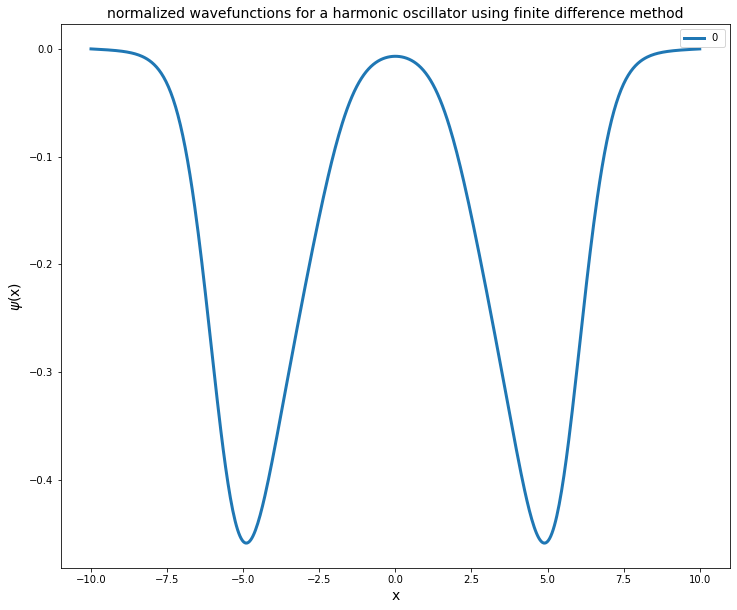

1.3325153410653177


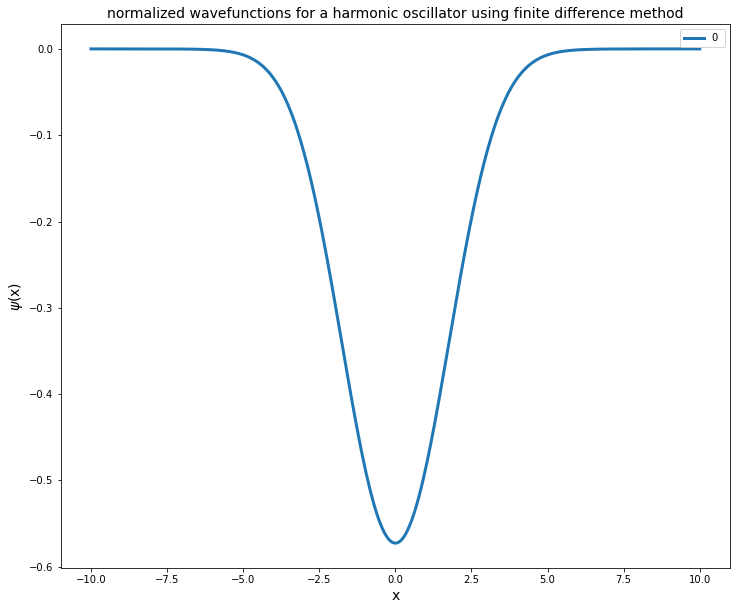

2.6426317029490844


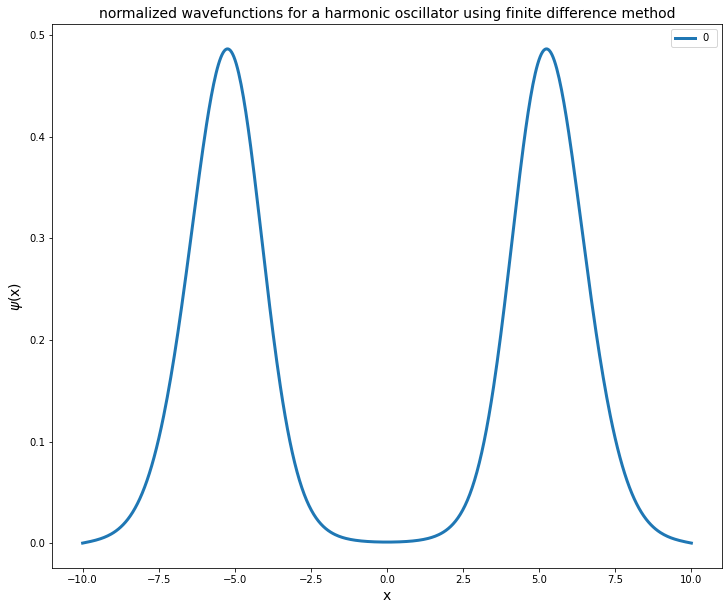

1.9424217990221013


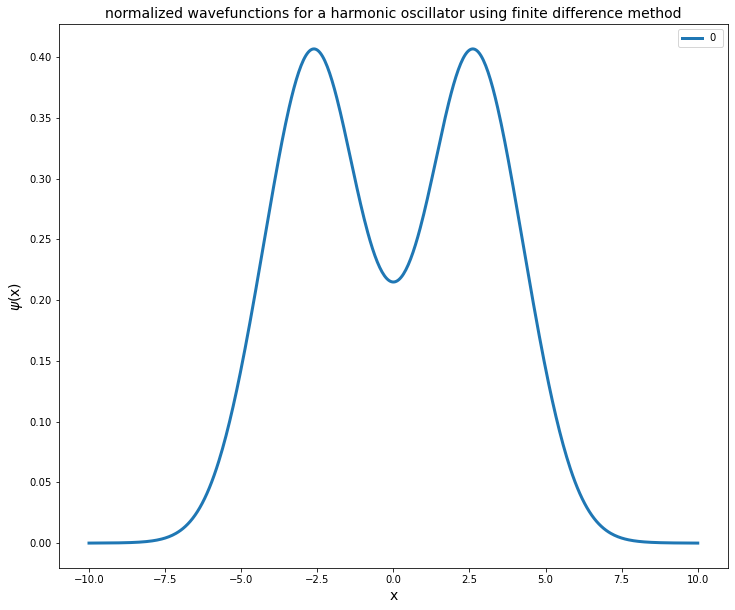

In [95]:
eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn1)
print(eig_val[0])
plot_finite_diff_sol(eig_val, -ground_state, DISCRETE_POINTS)

eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn2)
print(eig_val[0])
plot_finite_diff_sol(eig_val, -ground_state, DISCRETE_POINTS)

eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn3)
print(eig_val[0])
plot_finite_diff_sol(eig_val, -ground_state, DISCRETE_POINTS)

eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn4)
print(eig_val[0])
plot_finite_diff_sol(eig_val, -ground_state, DISCRETE_POINTS)

In [ ]:
# model_11_sin(layer_width=20, use_sin=True):
res1_11_sin = auto_test_documentation(model_11_sin, adam_opt_11_sin, p_fn1, 
                                      model_name='model_11_sin_pfn1',
                                      res_path=RESULT_PATH,
                                      loss_fname='loss_11_sin_pfn1',
                                      loss_with_pen_fname = 'loss_pen_11_sin_pfn1')

In [ ]:
res1_11_sigmoid = auto_test_documentation(model_11_sigmoid, adam_opt_11_sigmoid, p_fn1, 
                                      model_name='model_11_sigmoid_pfn1',
                                      res_path=RESULT_PATH,
                                      loss_fname='loss_11_sigmoid_pfn1',
                                      loss_with_pen_fname = 'loss_pen_11_sigmoid_pfn1')

In [ ]:
res1_21_sin = auto_test_documentation(model_21_sin, adam_opt_21_sin, p_fn1, 
                                      model_name='model_21_sin_pfn1',
                                      res_path=RESULT_PATH,
                                      loss_fname='loss_21_sin_pfn1',
                                      loss_with_pen_fname = 'loss_pen_21_sin_pfn1')

In [103]:
epsilon_Loss_penalty(p_fn1, res1_11_sin[3], LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)

(tensor([2.3111], grad_fn=<MulBackward0>),
 tensor([2.3111], grad_fn=<AddBackward0>))

In [ ]:
x_values = np.linspace(L_BOUND, U_BOUND, N_POINTS)
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in np.linspace(L_BOUND, U_BOUND, N_POINTS)]

model_output = model_on_interval(res2_11_sin[3], DISCRETE_POINTS)

plot_figure(x_values, model_output)
# plot_figure(x_values, model_output)

### The Finite Difference Method

In [22]:
def finite_diff_method(discrete_points, given_fn):
    N_points = len(discrete_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1]
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [23]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model=None):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    if nn_model != None:
        model_output = model_on_interval(nn_model, DISCRETE_POINTS)
        plt.plot(discrete_points, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [349]:
loss_val = epsilon_Loss_penalty(p_fn1, res1_21_sin[3], LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)[0]
print("The FD method eigenvalue: " + str(eig_val[0]))
print("The NN method loss value: " + str(loss_val.item()))

The FD method eigenvalue: 0.8500041525597394
The NN method loss value: 0.83415287733078


0.8500041525597394


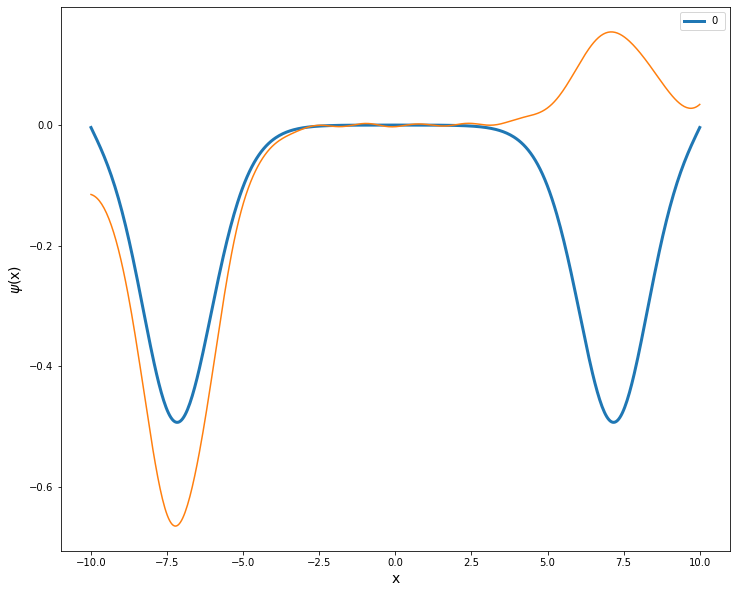

In [347]:
eig_val, ground_state = finite_diff_method(DISCRETE_POINTS, p_fn1)
print(eig_val[0])
plot_finite_diff_sol(eig_val, ground_state, DISCRETE_POINTS, res1_21_sin[3])

### Load Results for Display

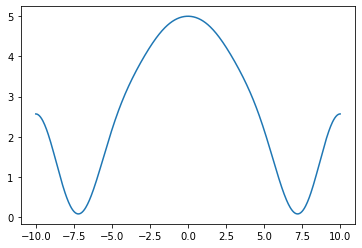

In [351]:
p_fn1.plot_function(DISCRETE_POINTS)